In [1]:
from pandas import DataFrame
# !pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd

dec_att = 'violentCrimesPerPop'

# fetch dataset
communities_and_crime = fetch_ucirepo(id=183)
df = pd.concat([communities_and_crime.data.features, communities_and_crime.data.targets], axis=1)
df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [2]:
def camelCase(word: str) -> str:
    return word[0].lower()+word[1:]

df.columns = list(map(camelCase, df.columns))
df.drop(columns=['fold', 'state', 'county', 'community', 'communityname' ], inplace=True)
import numpy as np
df.replace('?', np.nan, inplace=True)
df.drop(columns=df.columns[df.isnull().sum() > 1000], inplace=True)
df.shape

(1994, 101)

In [3]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df['otherPerCap'] = imputer.fit_transform(df[['otherPerCap']])
df["otherPerCap"].isna().sum()

0

In [4]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

# Importance

In [5]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
#sort
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

def get_importance_threshold_dataset(sorted_feature_importance_df, threshold):
    cumulative_importance = np.cumsum(sorted_feature_importance_df['Importance'])
    #Find the number of features needed to reach 90% importance
    num_features = np.argmax(cumulative_importance >= threshold) + 1

    pairs = zip(sorted_feature_importance_df['Feature'], sorted_feature_importance_df["Importance"])
    lowest_acceptable_importance = sorted_feature_importance_df["Importance"][::-1][num_features - 1]
    important_features = [f for f, imp in pairs if imp >= lowest_acceptable_importance]
    X_filtered = X[important_features]
    # print(f"Before: {sorted_feature_importance_df.shape[0]}; after: {X_filtered.shape[1]};")
    return X_filtered

In [6]:
datasets = {}
datasets["100%_importance"] = X
for threshold in range (30, 91, 10):
    datasets[f"{threshold:03d}%_importance"] = get_importance_threshold_dataset(feature_importance_df, threshold/100)

def print_datasets(datasets):
    for k,v in datasets.items():
        print(k, v.shape)
print_datasets(datasets)

100%_importance (1994, 100)
030%_importance (1994, 74)
040%_importance (1994, 69)
050%_importance (1994, 69)
060%_importance (1994, 3)
070%_importance (1994, 25)
080%_importance (1994, 85)
090%_importance (1994, 92)


In [7]:
# for k,v in datasets.items():
#     print(f'{k}: {"agePct12t29" in v.columns}')

# Train test split

In [8]:
from sklearn.model_selection import train_test_split
#to prevent data leakage
splits = {}
for dataset_name, dataset in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.25, random_state=42)
    splits[dataset_name] = {"X_train": X_train, "X_test":X_test, "y_train": y_train, "y_test":y_test}
for k, v in splits.items():
    print(k)
    print_datasets(v)
    print()

100%_importance
X_train (1495, 100)
X_test (499, 100)
y_train (1495,)
y_test (499,)

030%_importance
X_train (1495, 74)
X_test (499, 74)
y_train (1495,)
y_test (499,)

040%_importance
X_train (1495, 69)
X_test (499, 69)
y_train (1495,)
y_test (499,)

050%_importance
X_train (1495, 69)
X_test (499, 69)
y_train (1495,)
y_test (499,)

060%_importance
X_train (1495, 3)
X_test (499, 3)
y_train (1495,)
y_test (499,)

070%_importance
X_train (1495, 25)
X_test (499, 25)
y_train (1495,)
y_test (499,)

080%_importance
X_train (1495, 85)
X_test (499, 85)
y_train (1495,)
y_test (499,)

090%_importance
X_train (1495, 92)
X_test (499, 92)
y_train (1495,)
y_test (499,)



# Models

In [13]:
results = {
    "model_name":[],
    "mae":[],
    "mse":[],
    "r2":[],
    "time":[]
}
models = {}

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_model(model, dataset_name:str, t, suffix=None):#suffix only used in df naming
    pred = model.predict(splits[dataset_name]['X_test'])
    mae = mean_absolute_error(splits[dataset_name]['y_test'], pred)
    mse = mean_squared_error(splits[dataset_name]['y_test'], pred)
    r2 = r2_score(splits[dataset_name]['y_test'], pred)

    results["model_name"].append(f'{dataset_name}{suffix if suffix else ""}')
    results["mae"].append(mae)
    results["mse"].append(mse)
    results["r2"].append(r2)
    results["time"].append(t)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
def fit_and_eval(model, dataset_name:str, suffix=None):#suffix only used in df naming
    start = time.time()
    model.fit(splits[dataset_name]['X_train'], splits[dataset_name]['y_train'])
    t = time.time()-start
    eval_model(model, dataset_name, t, suffix)

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}
suffixes = {'xgb':"_xgb",'linreg':"_LinReg","rf":"_rf", "knn":"_KNN", 'bayes':"_Bayes"}

for dataset_name, spl in tqdm(splits.items()):
    #XGB
    print(f"{dataset_name}...")
    model = XGBRegressor(objective='reg:squarederror', random_state=42)
    search = RandomizedSearchCV(
        model, param_distributions=param_grid,
        n_iter=20, scoring='neg_root_mean_squared_error',
        cv=5, verbose=1, n_jobs=-1, random_state=42
    )
    search.fit(spl["X_train"], spl["y_train"])
    models[f'{dataset_name}{suffixes['xgb']}'] = search.best_estimator_ #returns xgb with best params for particular dataset
    fit_and_eval(models[f'{dataset_name}{suffixes['xgb']}'], dataset_name, suffixes['xgb'])
    print("XGB done")

    #LinReg
    model = LinearRegression()
    fit_and_eval(model, dataset_name, suffixes['linreg'])
    models[f'{dataset_name}{suffixes['linreg']}'] = model
    print("LinReg done")

    #RandomForest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    fit_and_eval(model, dataset_name, suffixes['rf'])
    models[f'{dataset_name}{suffixes['rf']}'] = model
    print("RandomForest done")

    #KNN
    model = KNeighborsRegressor(n_neighbors=5)
    fit_and_eval(model, dataset_name, suffixes['knn'])
    models[f'{dataset_name}{suffixes['knn']}'] = model
    print("KNN done")

    #Bayes
    model = BayesianRidge()
    fit_and_eval(model, dataset_name, suffixes['bayes'])
    models[f'{dataset_name}{suffixes['bayes']}'] = model
    print("Bayes done")

print(len(models.keys())) #should be 5x len(datsets.keys())

  0%|          | 0/8 [00:00<?, ?it/s]

100%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGB done
LinReg done


 12%|█▎        | 1/8 [00:36<04:17, 36.83s/it]

RandomForest done
KNN done
Bayes done
030%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGB done
LinReg done


 25%|██▌       | 2/8 [01:02<03:01, 30.20s/it]

RandomForest done
KNN done
Bayes done
040%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGB done
LinReg done


 38%|███▊      | 3/8 [01:26<02:16, 27.37s/it]

RandomForest done
KNN done
Bayes done
050%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGB done
LinReg done


 50%|█████     | 4/8 [01:50<01:44, 26.17s/it]

RandomForest done
KNN done
Bayes done
060%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGB done
LinReg done


 62%|██████▎   | 5/8 [01:52<00:52, 17.35s/it]

RandomForest done
KNN done
Bayes done
070%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGB done
LinReg done


 75%|███████▌  | 6/8 [02:01<00:28, 14.39s/it]

RandomForest done
KNN done
Bayes done
080%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGB done
LinReg done


 88%|████████▊ | 7/8 [02:31<00:19, 19.55s/it]

RandomForest done
KNN done
Bayes done
090%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGB done
LinReg done


100%|██████████| 8/8 [03:03<00:00, 22.99s/it]

RandomForest done
KNN done
Bayes done
40


In [16]:
df_results = pd.DataFrame(results)
df_results

,model_name,mae,mse,r2,time
0,100%_importance_xgb,0.089529,0.017551,0.639039,0.087132
1,100%_importance_LinReg,0.093706,0.016935,0.651719,0.012530
2,100%_importance_rf,0.092143,0.017299,0.644231,4.586398
3,100%_importance_KNN,0.097210,0.019640,0.596081,0.001001
4,100%_importance_Bayes,0.091570,0.016665,0.657269,0.010511
5,030%_importance_xgb,0.090361,0.017730,0.635377,0.068085
6,030%_importance_LinReg,0.094303,0.017364,0.642886,0.006509
7,030%_importance_rf,0.092119,0.017228,0.645696,3.509451
8,030%_importance_KNN,0.098814,0.020515,0.578088,0.001503
9,030%_importance_Bayes,0.092472,0.017059,0.649176,0.004509


In [100]:
model_types = set([model_label.split("_")[-1] for model_label in df_results["model_name"].unique()])
def color_generator(n_colors, cmap_name='tab20'):
    cmap = plt.get_cmap(cmap_name, n_colors)
    for i in range(n_colors):
        yield cmap(i)

color_gen = color_generator(len(model_names))
model_colors = {}
for model_type in model_types:
    type_subset = df_results[df_results['model_name'].str.contains(model_type, na=False)]
    color = next(color_gen)
    for model_name in type_subset['model_name']:
        model_colors[model_name] = color

print(len(model_colors))

40


In [101]:
import matplotlib.pyplot as plt
import numpy as np
def plot_results(metric_name, model_name, asc=True, bottom=None, top=None):
    if model_name=="all":
        model_names = df_results["model_name"]
        metric_values = df_results[metric_name]

    elif model_name=='champions':
        champion_df = pd.DataFrame(columns=["model_name", metric_name])
        for model_type in model_types:
            type_subset = df_results[df_results['model_name'].str.contains(model_type, na=False)]
            if asc:
                champion_row = type_subset.loc[type_subset[metric_name].idxmin()]
            else:
                champion_row = type_subset.loc[type_subset[metric_name].idxmax()]
            champion_df = pd.concat([champion_df, pd.DataFrame([champion_row[['model_name', metric_name]]])])

        model_names = champion_df["model_name"]
        metric_values = champion_df[metric_name]

    else:
        model_names = df_results[df_results['model_name'].str.contains(model_name, na=False)]["model_name"]
        metric_values = df_results[df_results['model_name'].str.contains(model_name, na=False)][metric_name]

    # Sort data
    sorted_data = sorted(zip(model_names, metric_values), key=lambda item: item[1], reverse=not asc)
    sorted_model_names, sorted_metric_values = zip(*sorted_data)

    # Positioning bars
    x_pos = np.arange(len(sorted_model_names))

    # Create plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(x_pos, sorted_metric_values, color=[model_colors.get(model, 'grey') for model in sorted_model_names])  # Use model-specific colors

    # Add labels and title
    plt.xlabel("Models")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} of {model_name}")
    plt.xticks(x_pos, sorted_model_names, rotation=45, ha='right')

    # Add value labels on top of each bar
    for bar, score in zip(bars, sorted_metric_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.5f}', ha='center', va='bottom')

    # Adjust layout
    plt.tight_layout()

    # Set limits if bottom or top values are provided
    plt.ylim(bottom if bottom is not None else plt.ylim()[0], top if top is not None else plt.ylim()[1])
    # Show plot
    plt.show()


In [110]:
def summarize_metric(metric_name, asc):
    plot_results(metric_name, 'xgb', asc)
    plot_results(metric_name, 'LinReg', asc)
    plot_results(metric_name, 'rf', asc)
    plot_results(metric_name, 'KNN', asc)
    plot_results(metric_name, 'Bayes', asc)
    plot_results(metric_name, 'champions', asc)
import warnings
warnings.filterwarnings("ignore")

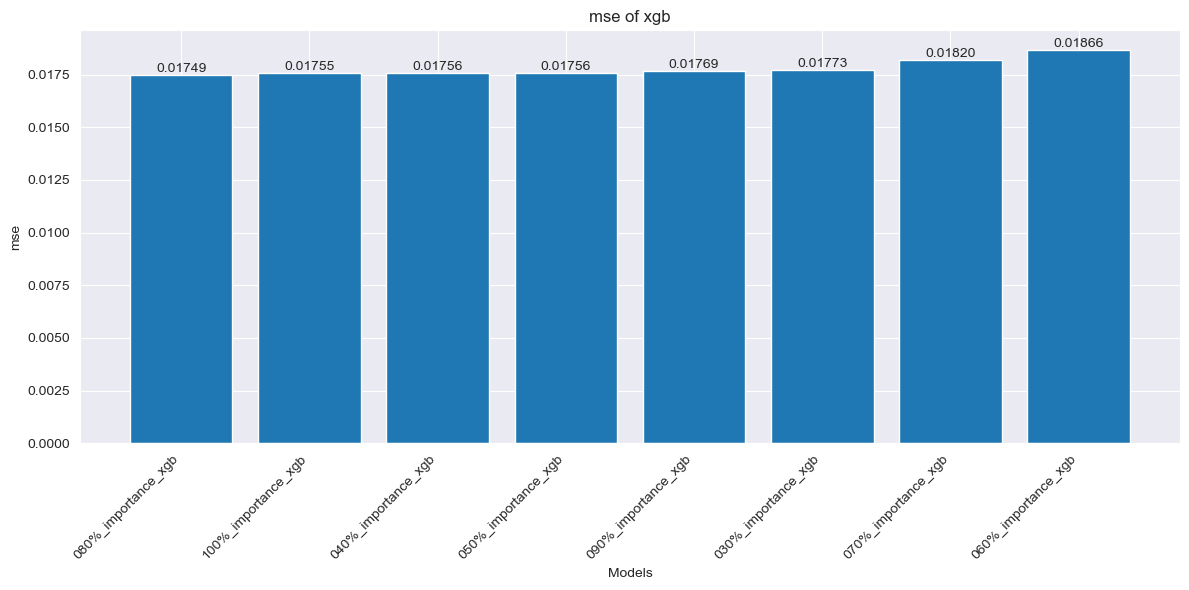

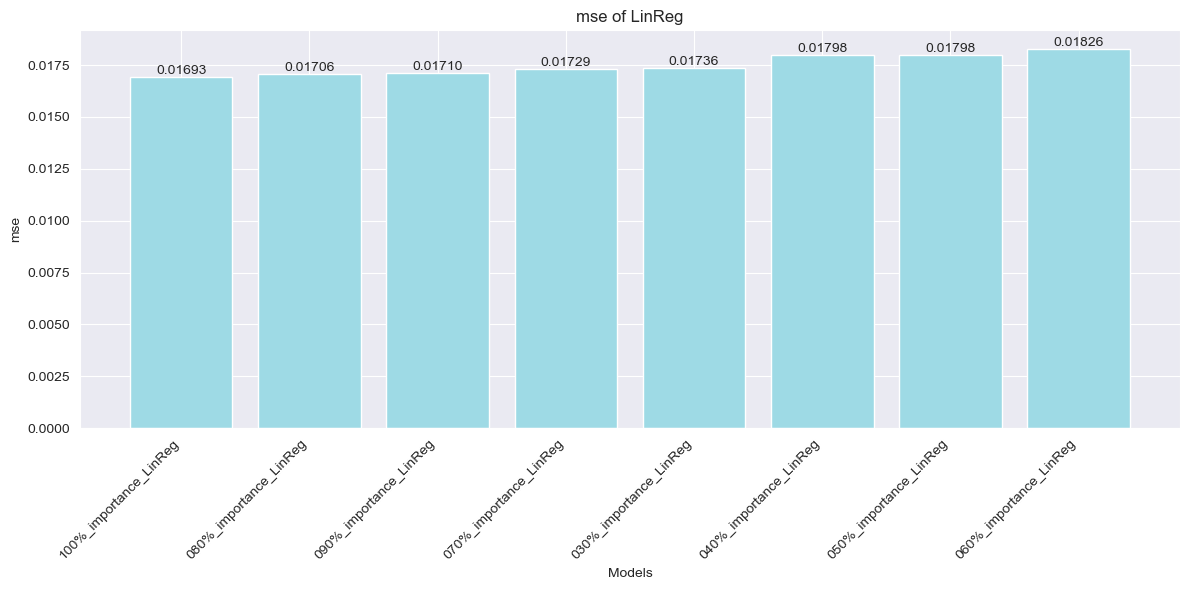

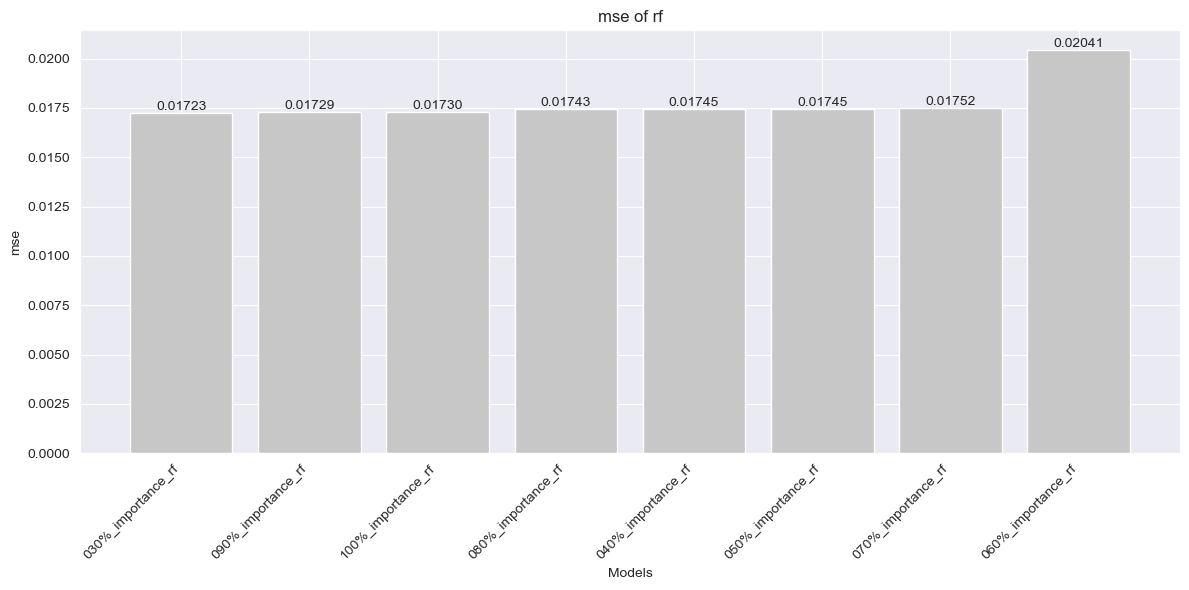

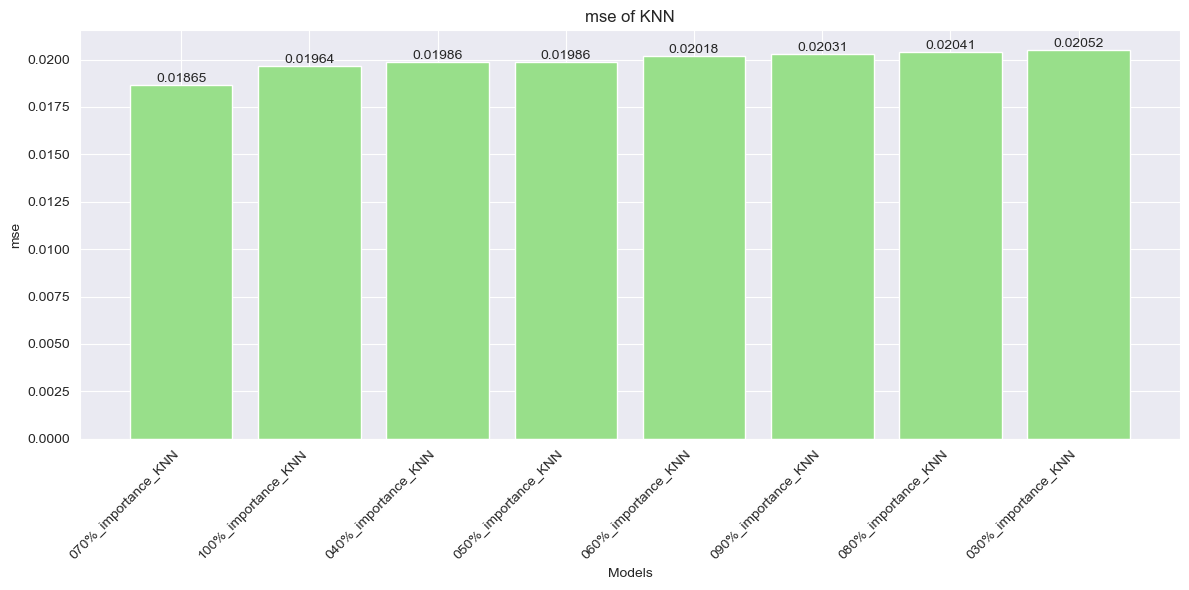

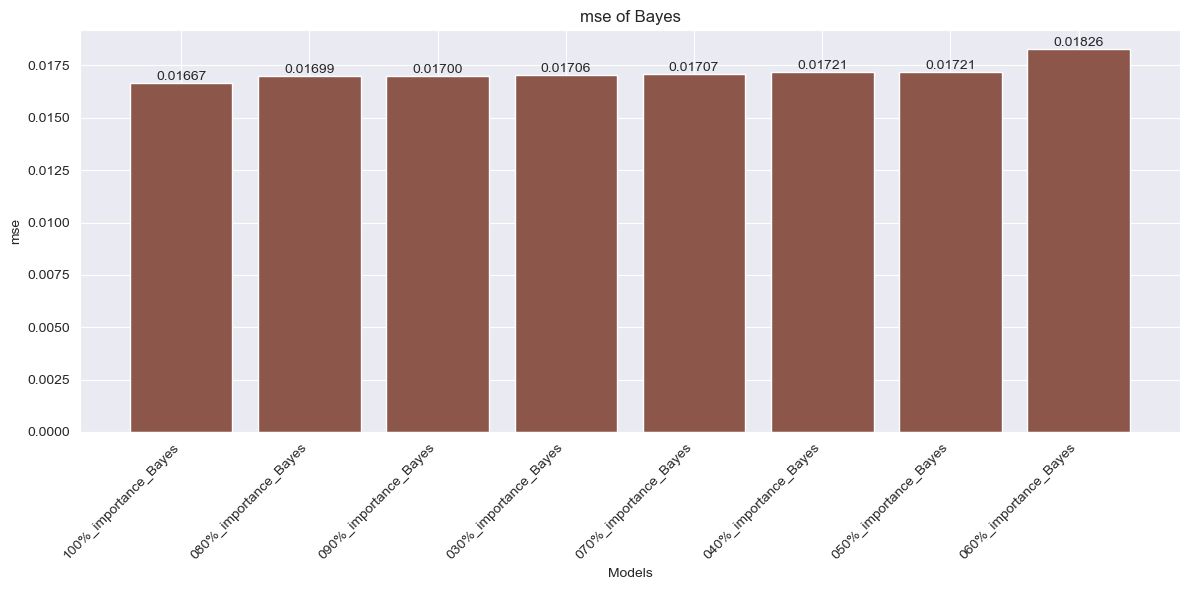

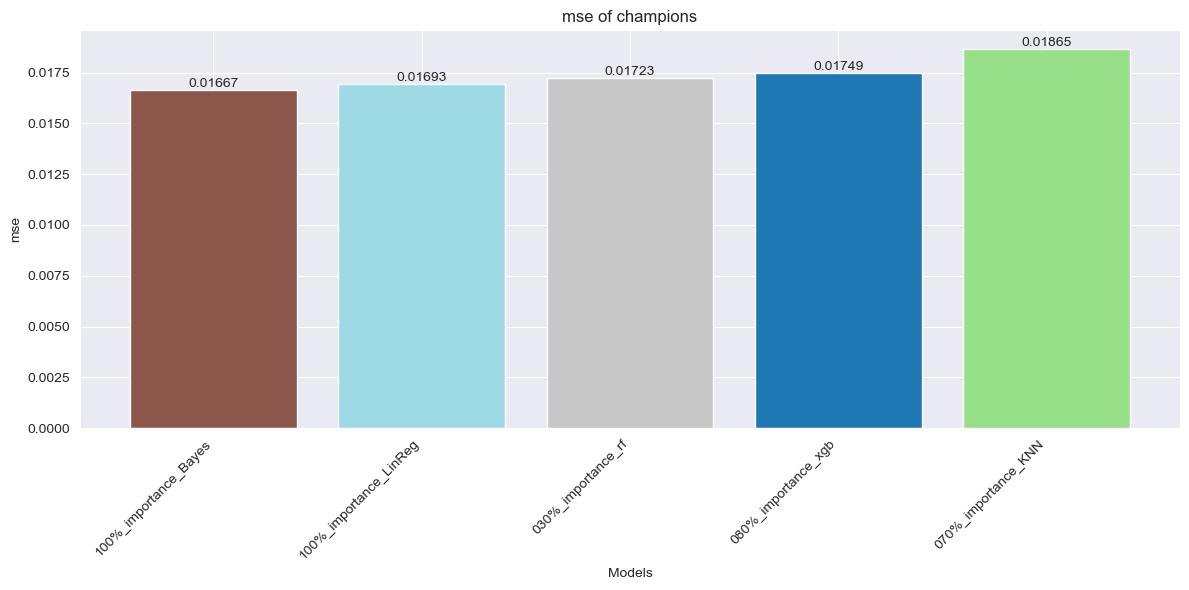

In [111]:
summarize_metric('mse', True)

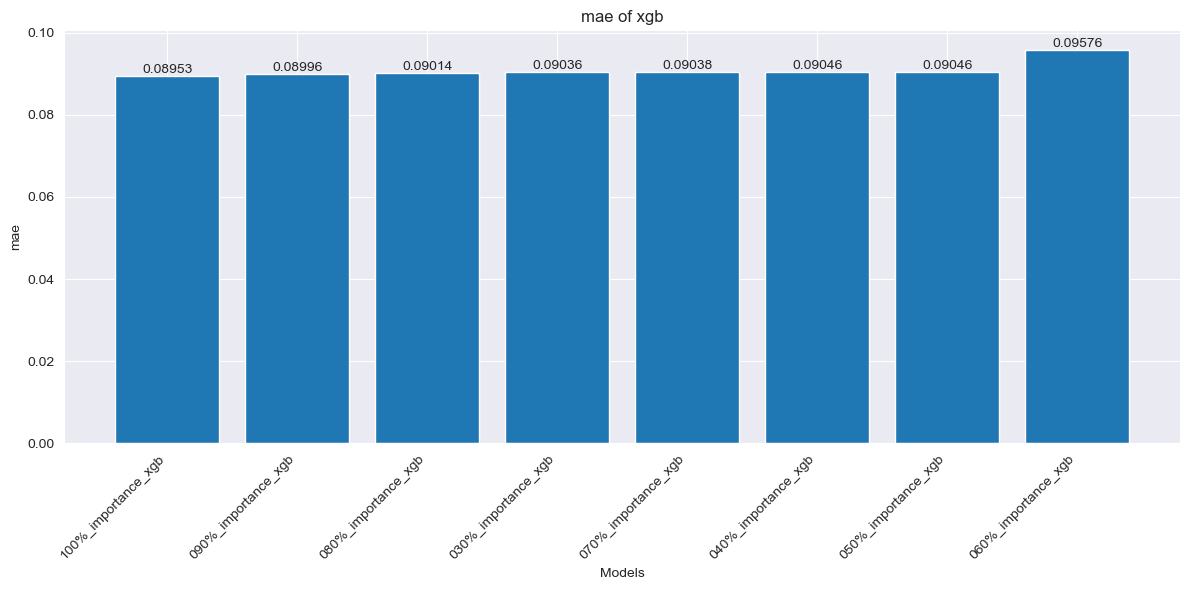

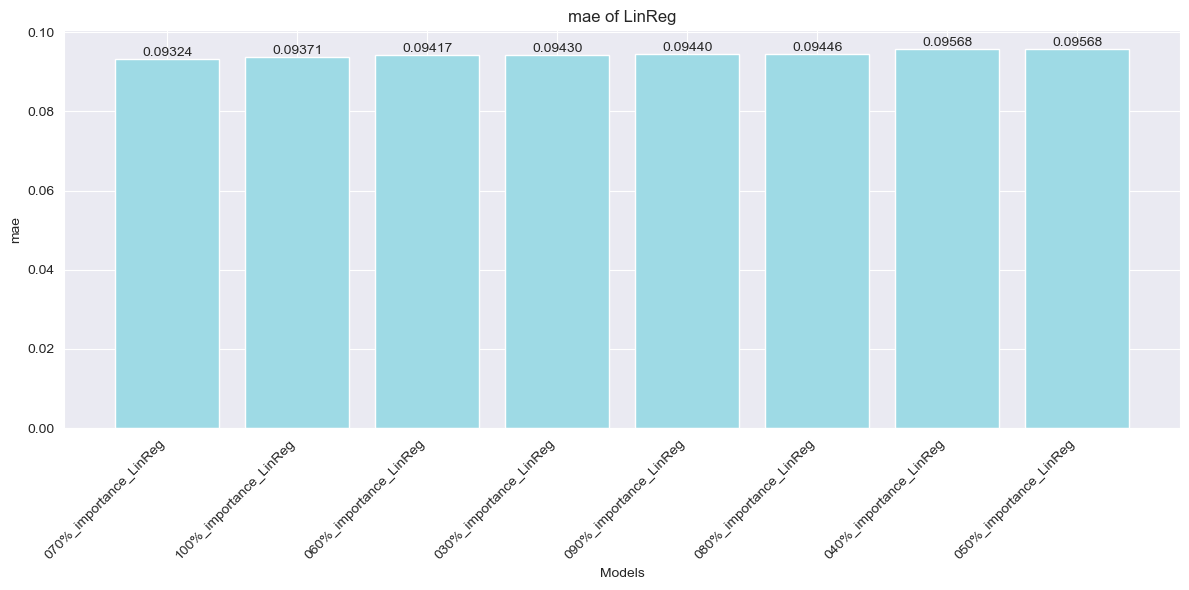

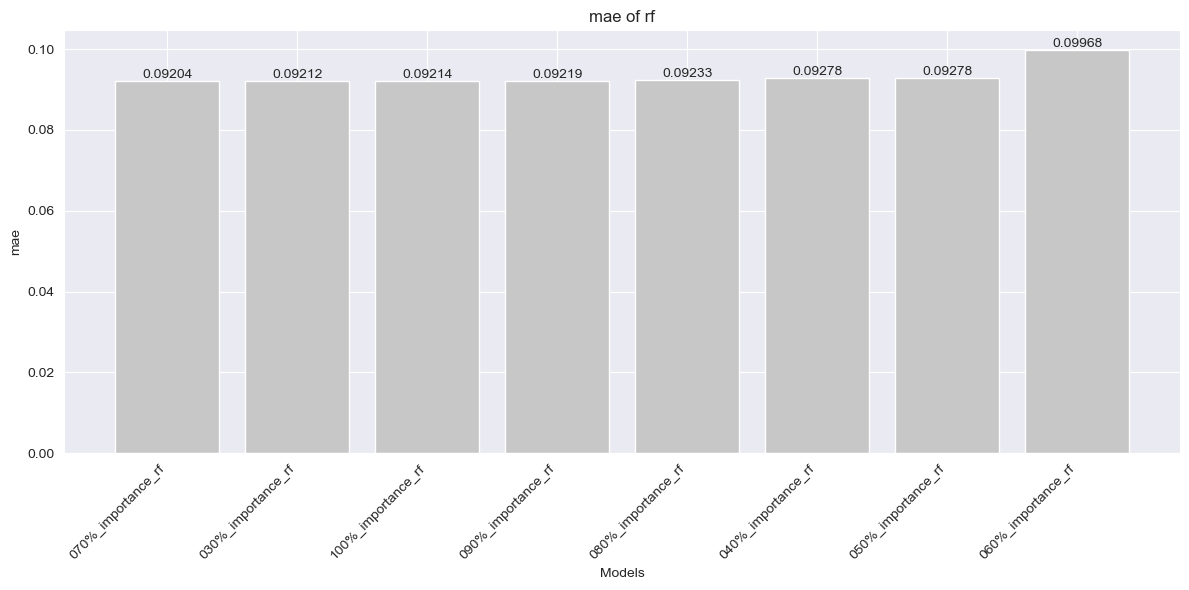

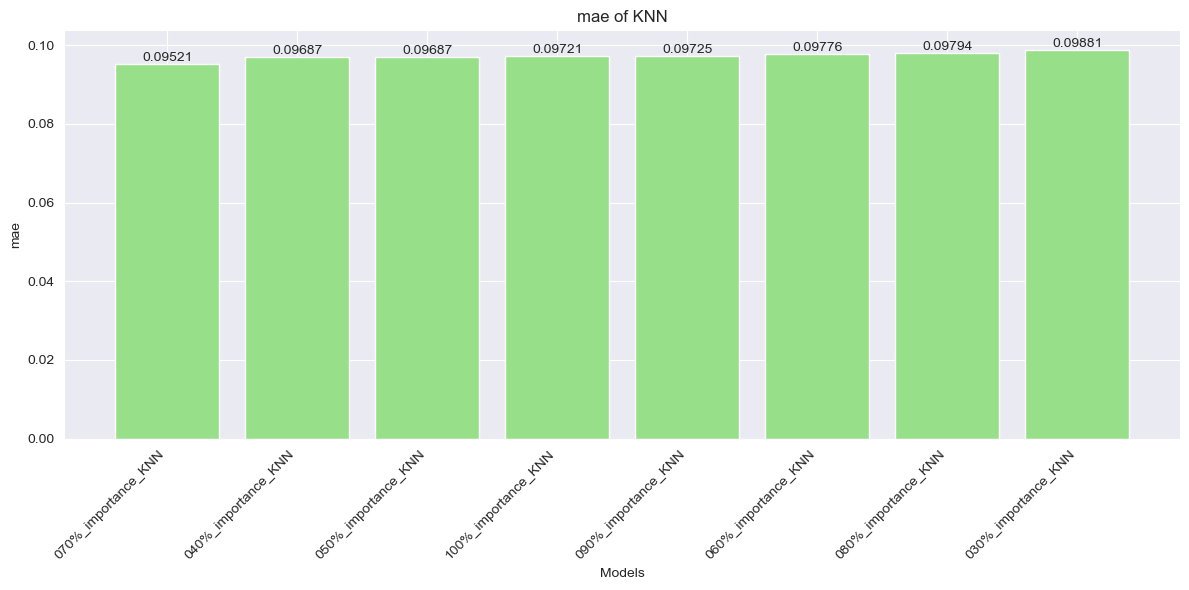

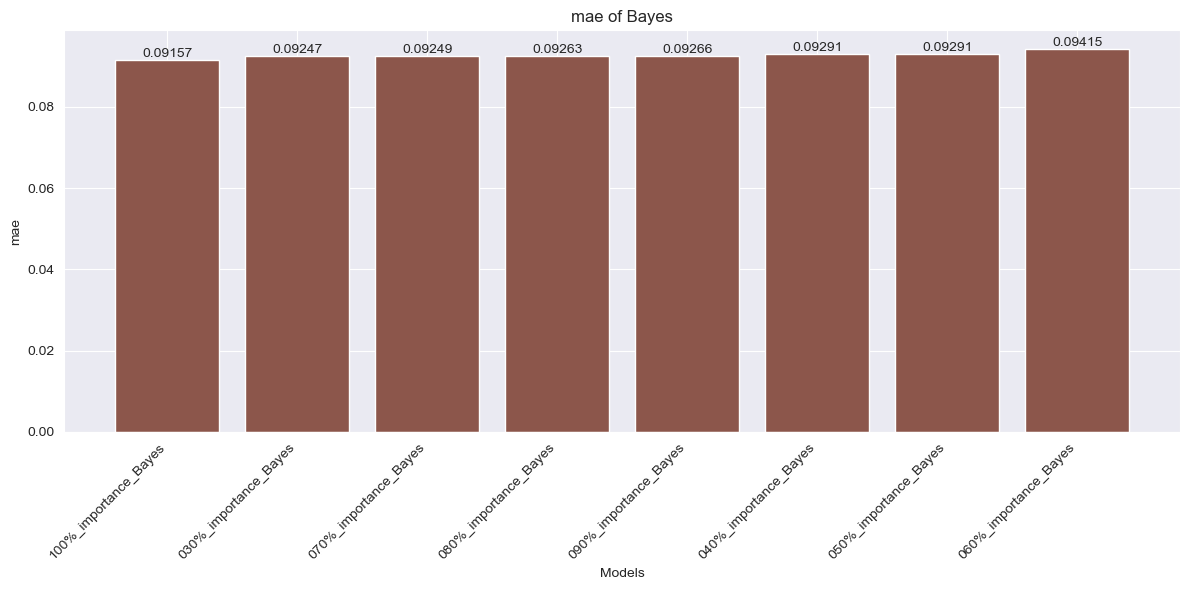

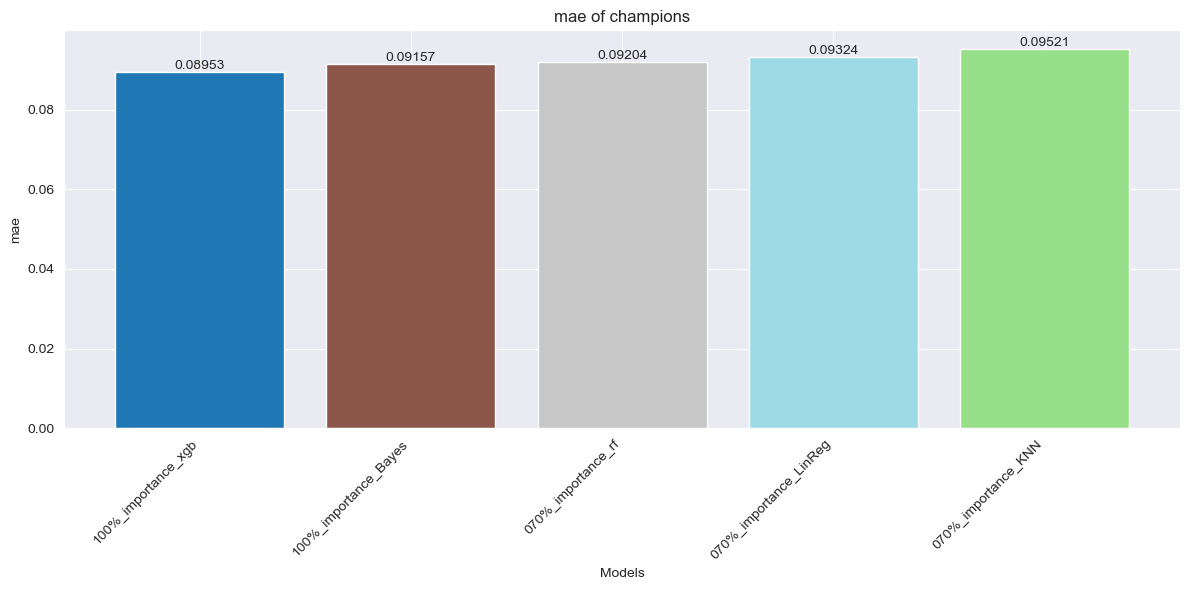

In [112]:
summarize_metric('mae', True)

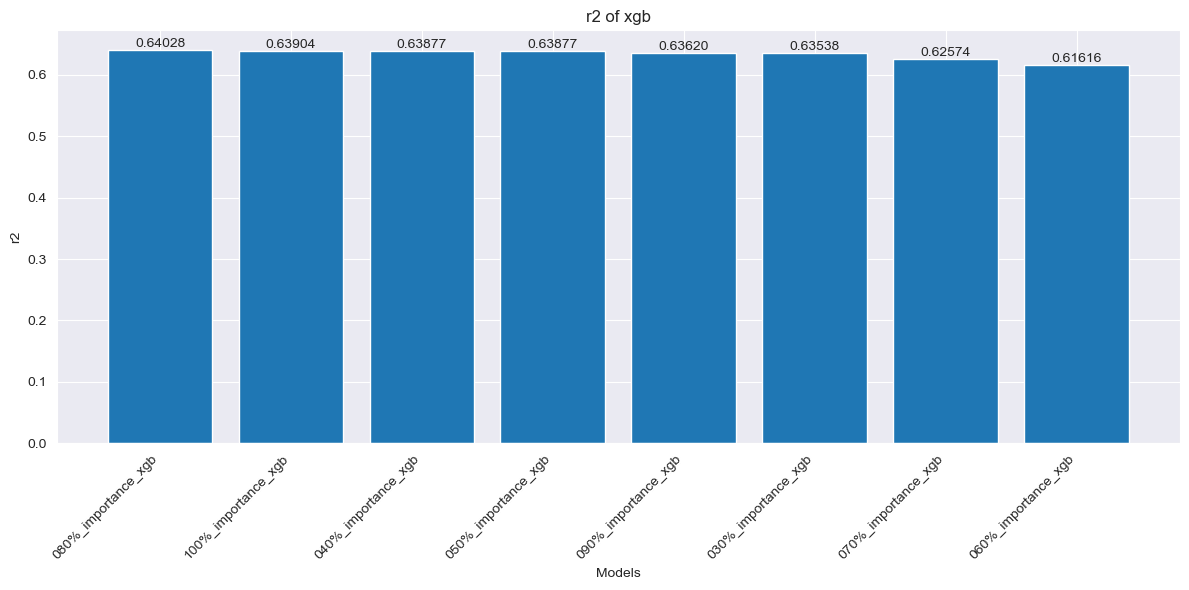

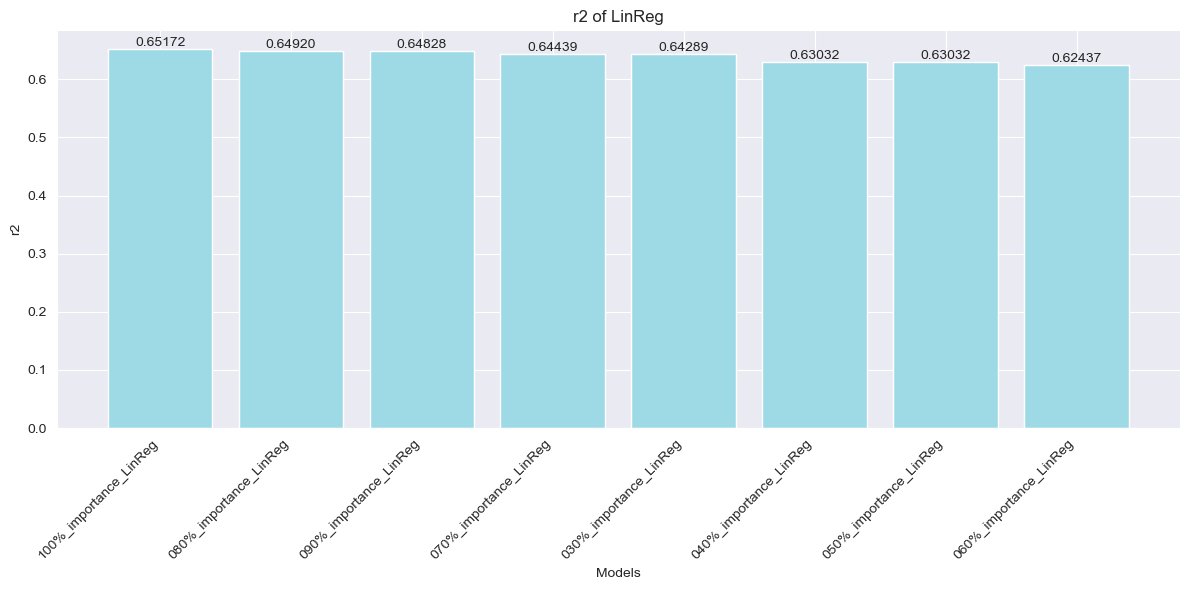

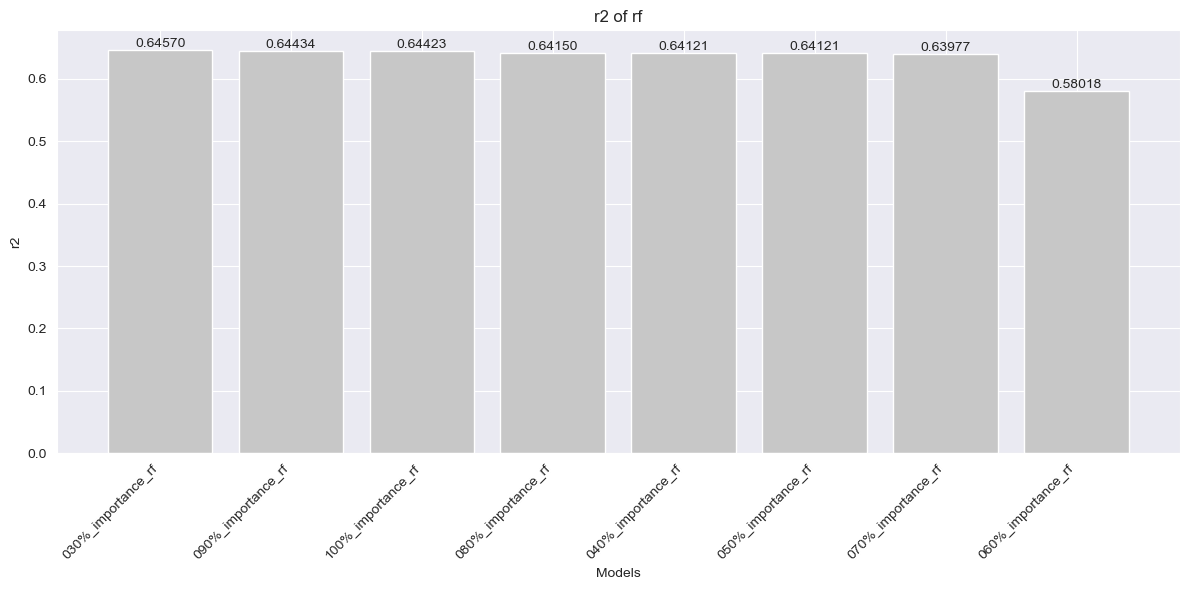

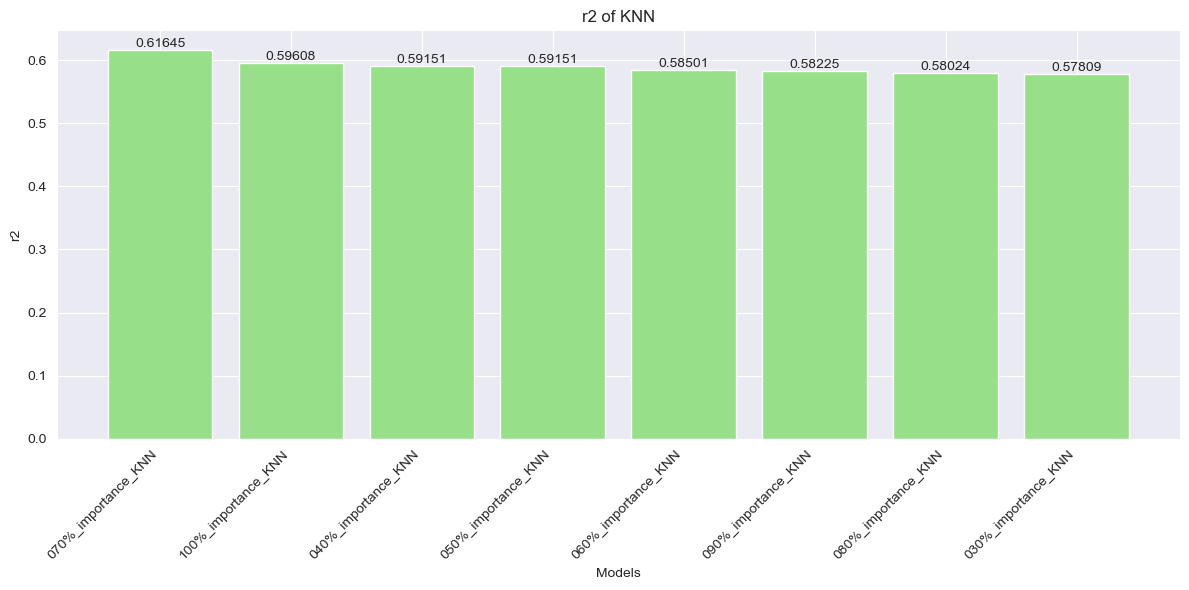

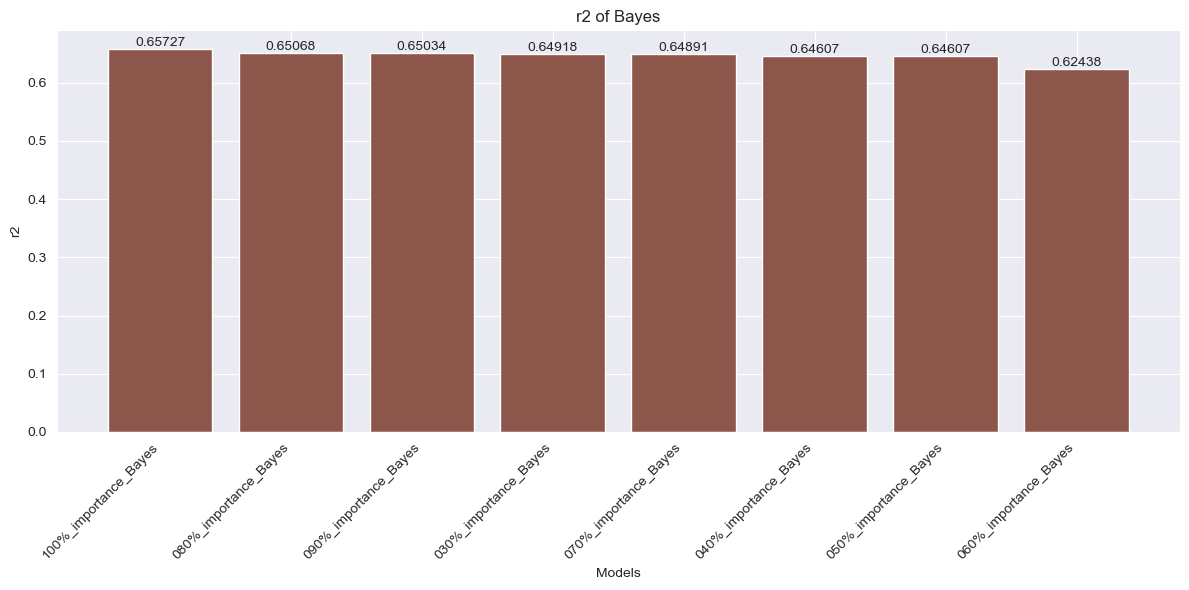

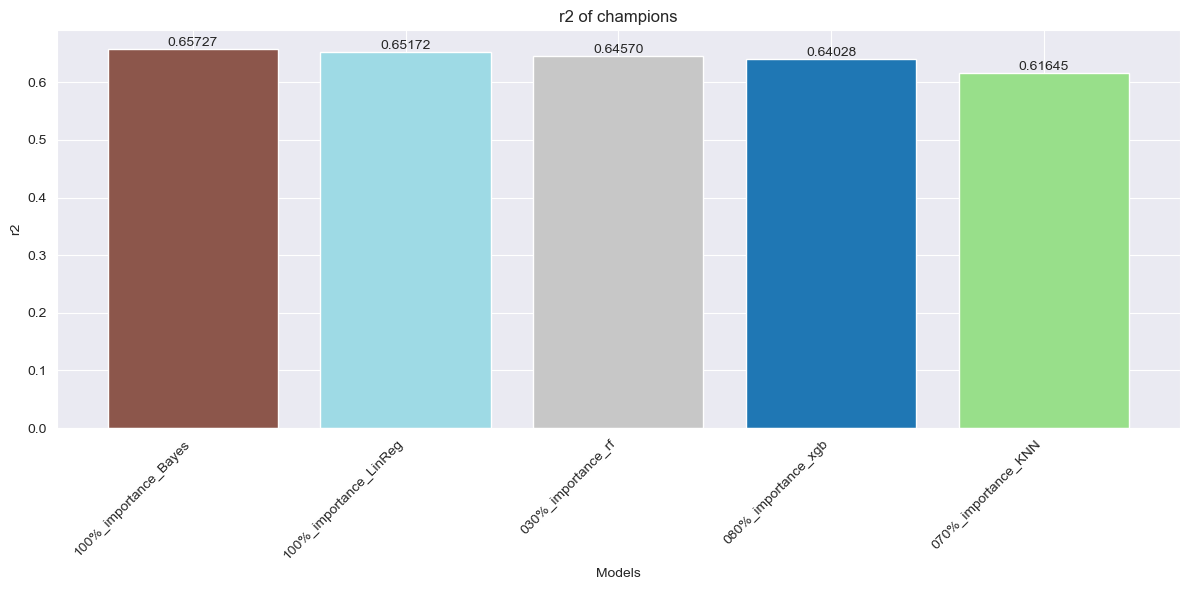

In [113]:
summarize_metric('r2', False)

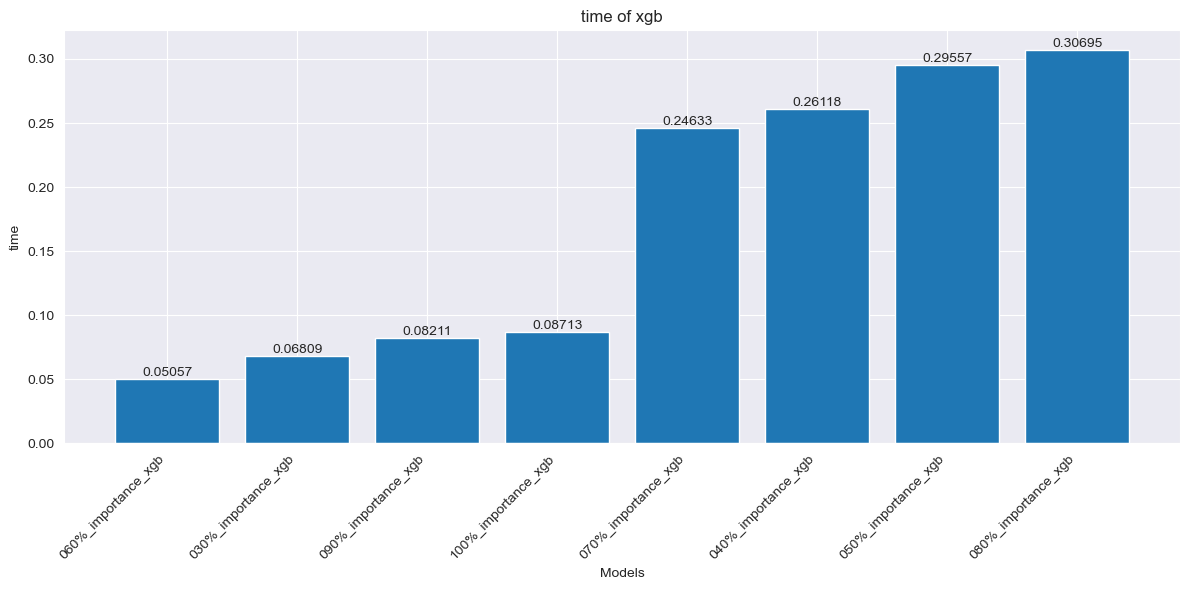

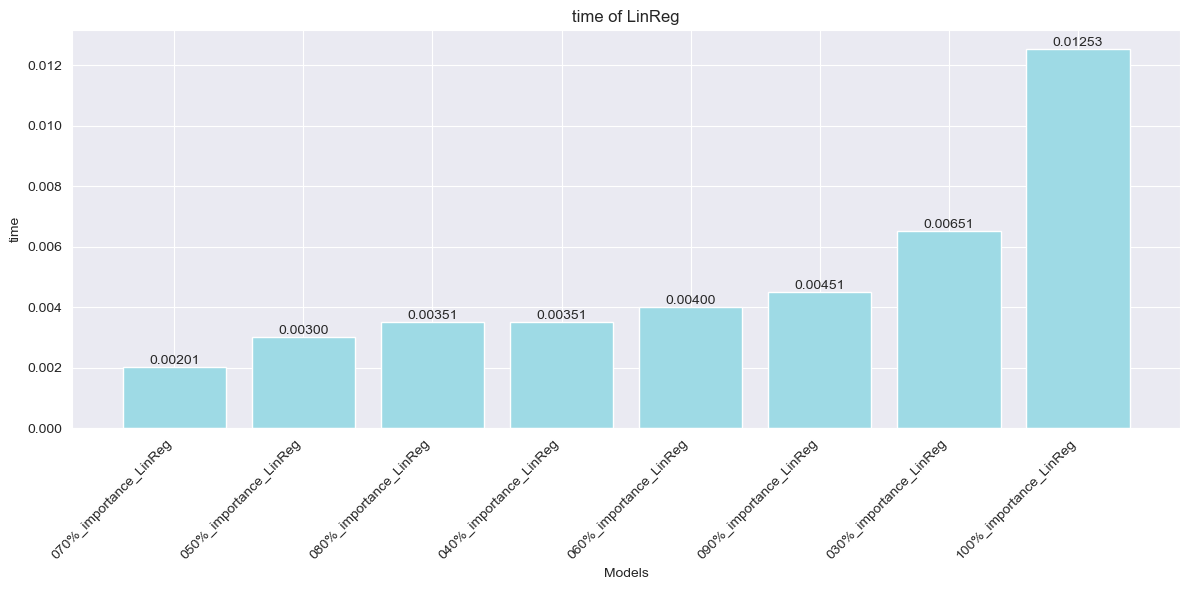

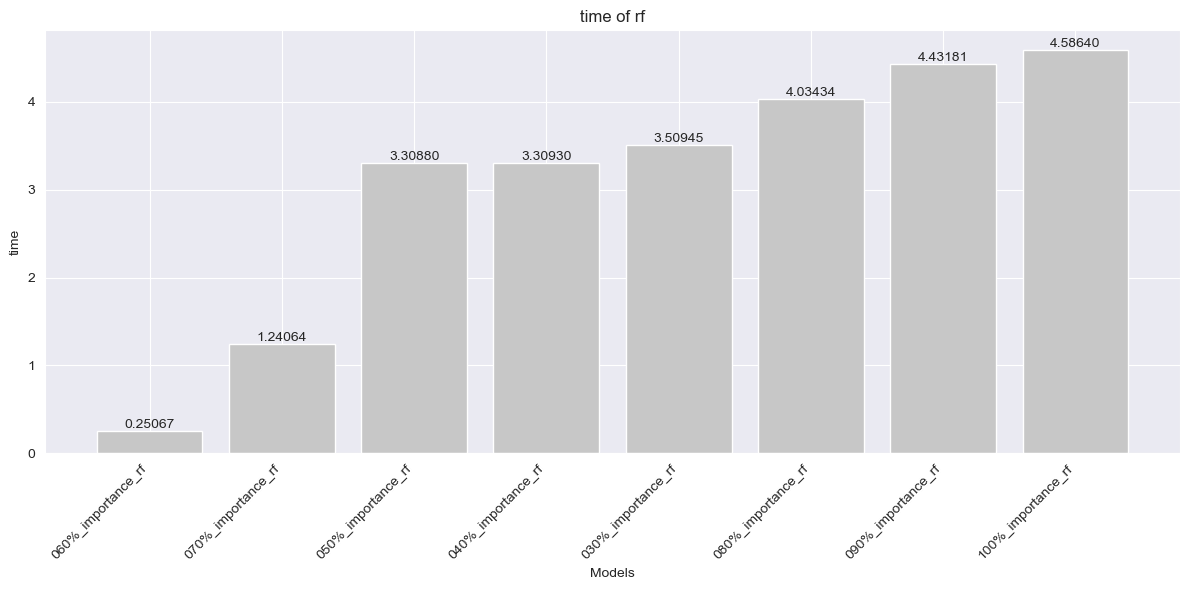

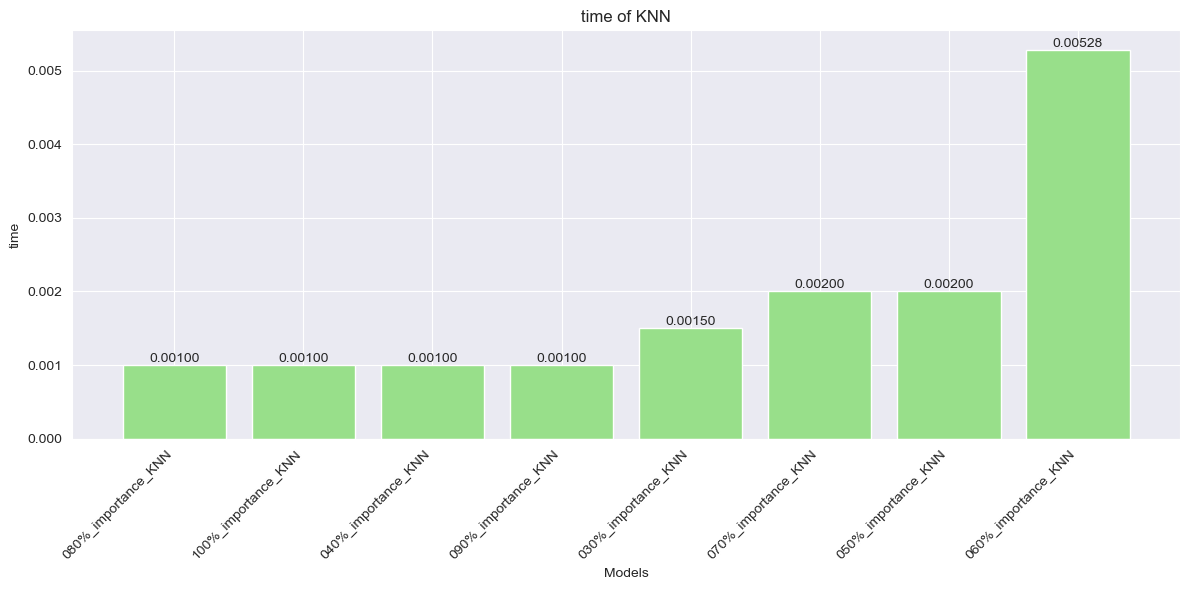

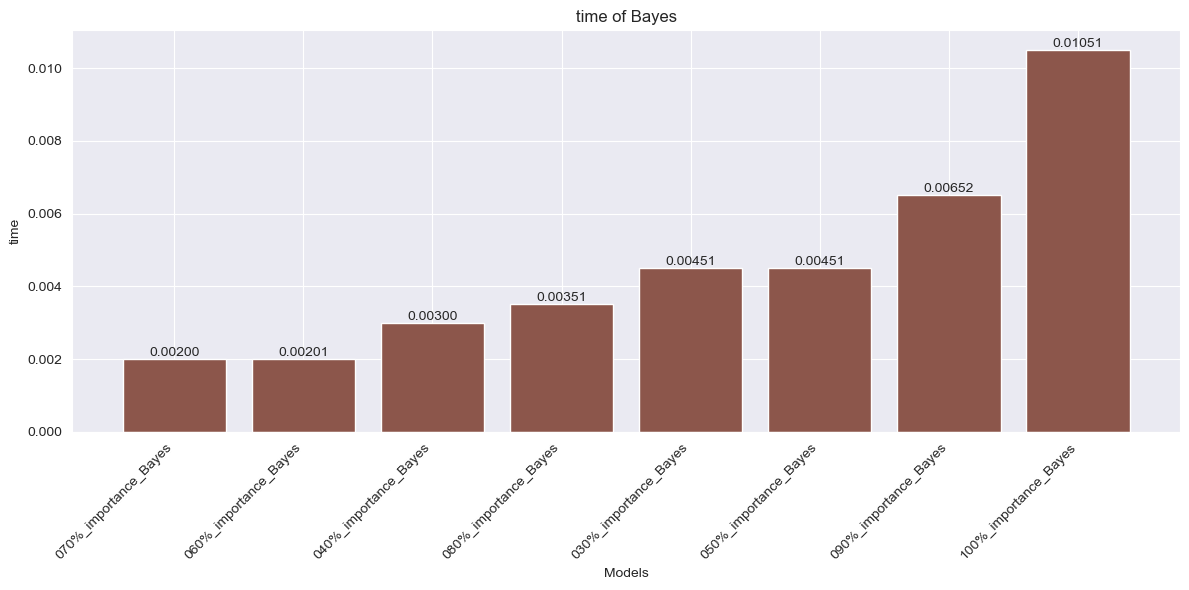

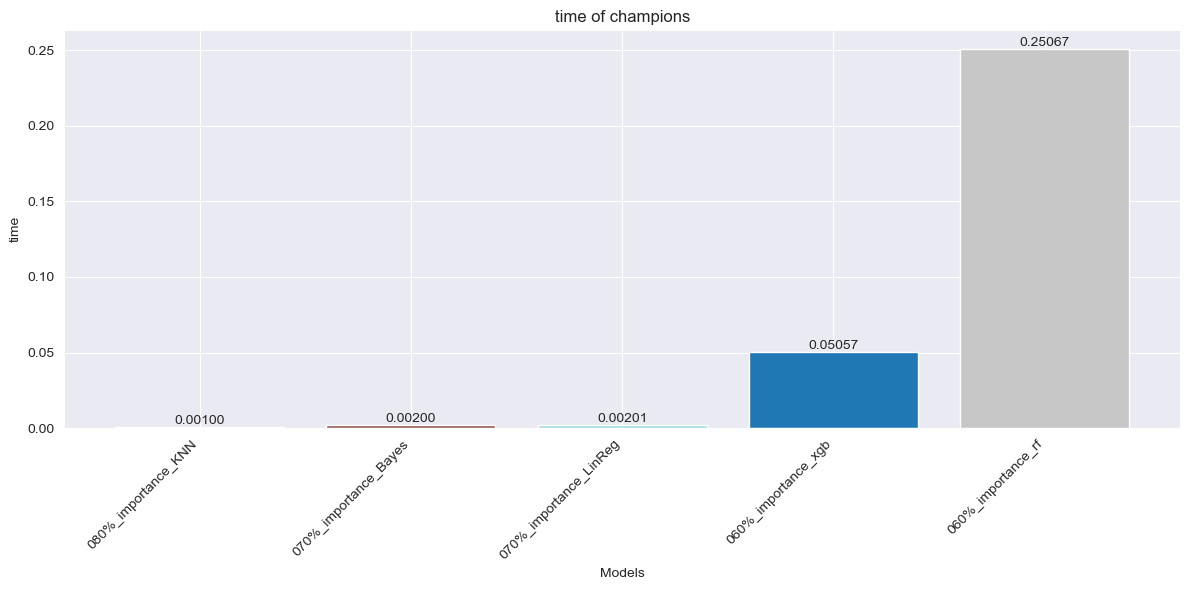

In [114]:
summarize_metric('time', True)